In [8]:
import os
import re
import pandas as pd
import numpy as np
from skimage import measure
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage import exposure, filters
from sklearn import metrics

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

**Estos, que incluyen el auc, están hechos con ClipLimit = 2**

- python entrenar_modelo_exe.py -d 1 -n unsupervised_256 -px 256 -m False
- python entrenar_modelo_exe.py -d 1 -n unsupervised_mask_256 -px 256 -m True
- python entrenar_modelo_exe.py -d 1 -n unsupervised_512 -px 512 -m False
- python entrenar_modelo_exe.py -d 1 -n unsupervised_mask_512 -px 256 -m True

**Estos están hechos sin especificar ClipLimit**
- unsupervised_256
- unsupervised_512

# FUNCIONES

In [10]:
def create_dataframe(folder, path = '/home/mr1142/Documents/Data/chest_xray'):
    path = os.path.join('/home/mr1142/Documents/Data/chest_xray', folder)
    for fold in os.listdir(path):
        globals()[fold] = {}
        imgs = os.listdir(os.path.join(path, fold))
        globals()[fold]['path'] = [os.path.join(path, fold)] * len(imgs)
        globals()[fold]['img_name'] = imgs
        globals()[fold]['normal'] = [1 if fold == 'NORMAL' else 0 for _ in range(len(imgs))]
        globals()[fold]['viral'] = [1 if re.search('virus', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['bacteria'] = [1 if re.search('bacteria', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['real'] = [0 if fold == 'NORMAL' else 1 if re.search('virus', imgs[i]) else 2 for i in range(len(imgs))]

    for k, v in PNEUMONIA.items():
        v.extend(NORMAL[k])

    df = pd.DataFrame(PNEUMONIA)

    return df

In [11]:
def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)


def quitar_trozos(mask):
    mask = measure.label(mask)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((5,5)))
    return mask


def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_16UC1)


def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask


def list_files(path):
    return [f for f in os.listdir(path) 
                if os.path.isfile(os.path.join(path, f))]

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


mask_model = keras.models.load_model('/home/mr1142/Documents/Data/models/mascaras/mask_1.h5', 
                                    custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})
sub_mask = keras.Model(inputs=mask_model.input, outputs=mask_model.layers[18].output)
sub_mask.trainable = False


def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return 0.6*abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + loss2
    return loss


model = os.path.join('/home/mr1142/Documents/Data/models/mascaras/unet_final_renacimiento_validation_6.h5')
model = keras.models.load_model(model, 
                                    custom_objects={"MyLoss": MyLoss, 
                                                    "loss_mask": loss_mask, 
                                                    "dice_coef_loss": dice_coef_loss,
                                                    "dice_coef": dice_coef})

def clahe(img):
    clahe = cv2.createCLAHE()
    img = np.uint8(img)
    final_img = clahe.apply(img)
    final_img = np.expand_dims(final_img, axis=-1)
    return final_img


def get_prepared_img(img, pix, mask = True, clahe_bool = False):
    if mask:
        img = des_normalize(apply_mask(img, model))
    img = recolor_resize(img, pix)
    if clahe_bool:
        img = clahe(img)
    img = normalize(img)
    return img

In [12]:
def custom_binary_loss(y_true, y_pred): 
    # https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/backend.py#L4826
    y_true = K.cast(y_true, 'float32')
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  # Cancels out when target is 1 
    term_1 = y_true * K.log(y_pred + K.epsilon()) # Cancels out when target is 0
    suma = term_0 + term_1
    return -K.mean(suma, axis=1)+K.std(suma, axis = 1)


def custom_binary_loss_2(y_true, y_pred): 
    y_true = K.cast(y_true, 'float32')
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    san = K.sum(1-y_true, axis = 0)
    enf = K.sum(y_true, axis = 0)
    dif_sanos = (1 - y_true) * K.abs(y_true-y_pred)  # Cancels out when target is 1 
    dif_sanos = K.sum(dif_sanos, axis = 0)/san
    dif_enf = y_true * K.abs(y_true-y_pred) # Cancels out when target is 0
    dif_enf = K.sum(dif_enf, axis = 0)/enf
    suma = dif_enf + dif_sanos + K.abs(dif_enf-dif_sanos)
    return K.mean(suma)+K.std(suma)

In [13]:
def AUC_plot(fpr, tpr, thresholds, auc):
    fig, ax = plt.subplots()
    i = np.argmax(tpr-fpr)
    th = thresholds[i]
    x = fpr[i]
    y = tpr[i]
    ax.plot(fpr,tpr, "g-", label="AUC="+str(round(auc, 2)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    try:
        ax.plot([x, x], [0, y], "r:")
        ax.plot([0, x], [y, y], "r:")
    except:
        print('plot except')
    ax.plot([x], [y], "ro", label="th="+str(round(th,2))) 
    ax.legend(loc=4)
    return fig

# EJECUCIÓN

In [14]:
pixels = 256

In [15]:
df = create_dataframe('test')

In [16]:
len(df)

624

In [17]:
model_path = '/home/mr1142/Documents/Data/models/unsupervised_' + str(pixels) + '.h5'
backbone = tf.keras.models.load_model(model_path)

In [18]:
model_path = '/home/mr1142/Documents/Data/models/neumonia_pediatric/unsupervised_loss1_256_auc-90.h5'
neumonia_model = tf.keras.models.load_model(model_path, custom_objects={'custom_binary_loss': custom_binary_loss})

In [19]:
path_cruces = '/home/mr1142/Documents/Data/prueba_cruces'
imgs = os.listdir(path_cruces)

In [20]:
i = np.random.randint(0,len(df))
print(i)
img = cv2.imread(os.path.join(df['path'][i], df.img_name[i]))

619


In [21]:
i = 0

In [22]:
# i = np.random.randint(0,len(imgs))
print(i)
img = cv2.imread(os.path.join(path_cruces, imgs[i]))
i = i+1

0


In [23]:
img.shape

(3480, 4240, 3)

In [24]:
prepared_img = get_prepared_img(img,pixels,mask = True, clahe_bool = True)
predicted = backbone.predict(np.expand_dims(prepared_img, axis = 0))

2022-09-14 16:21:34.305279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-14 16:21:34.305718: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3598155000 Hz
2022-09-14 16:21:34.620579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-14 16:21:38.308880: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-14 16:21:38.363071: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-14 16:21:38.958746: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [25]:
prepared_img.shape

(256, 256, 1)

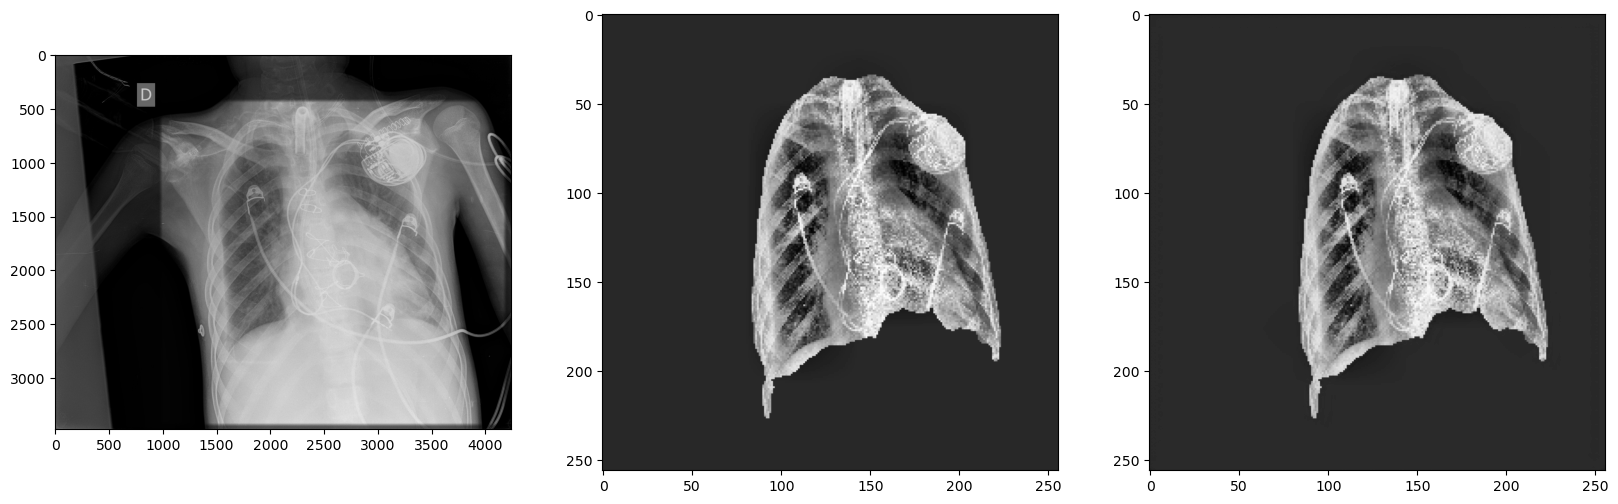

In [26]:
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(prepared_img, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(predicted[0,...], cmap = 'gray')
plt.show()

# Prediccion de neumonia

In [27]:
neumonia_model.predict(np.expand_dims(prepared_img, axis = 0))

array([[0.50963473, 0.31478623, 0.3881913 ]], dtype=float32)

In [28]:
imgs[i-1]

'PAC2 4 POST5D.jpeg'

In [29]:
df[['normal', 'viral', 'bacteria']].iloc[i]

normal      0
viral       0
bacteria    1
Name: 1, dtype: int64

# AUC

In [67]:
imgs = [im for im in imgs if not re.search('POST', im)]
true = [1 if re.search('NEUMO', im) else 0 for im in imgs]

In [62]:
pred = [neumonia_model.predict(np.expand_dims(get_prepared_img(cv2.imread(os.path.join(path_cruces, im)),pixels,mask = True, clahe_bool = True), axis = 0)) for im in imgs]

In [52]:
subset = pd.concat([df.iloc[:50], df.iloc[:-50]], ignore_index = True)
imgs = [os.path.join(subset.path[i], subset.img_name[i]) for i in subset.index]
true = list(subset.normal)

In [54]:
pred = [neumonia_model.predict(np.expand_dims(get_prepared_img(cv2.imread(im),pixels,mask = True, clahe_bool = True), axis = 0)) for im in imgs]

In [63]:
pred = np.vstack(pred)

In [64]:
fpr, tpr, auc_thresholds = metrics.roc_curve(true, pred[:,0])
auc = metrics.auc(fpr, tpr)

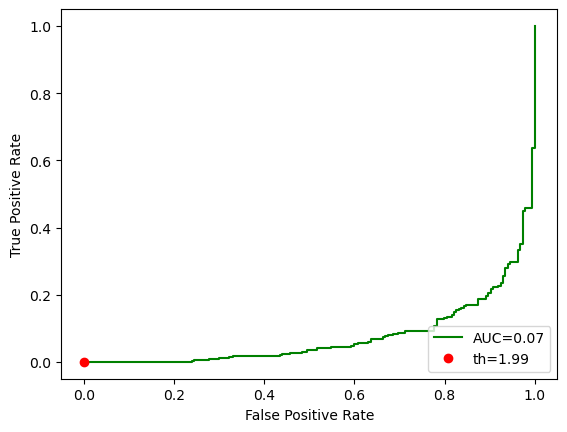

In [65]:
a = AUC_plot(fpr,tpr,auc_thresholds,auc)

In [66]:
d = pd.DataFrame()
d['true'] = true
d['pred'] = pred[:,0]
d

,true,pred
0,1,0.243968
1,1,0.173340
2,1,0.165947
3,1,0.351553
4,1,0.157799
...,...,...
619,0,0.957552
620,0,0.689478
621,0,0.434671
622,0,0.396370
